In [1]:

import csv
import networkx as nx
import matplotlib.pyplot as plt

import pandas as pd
import numpy  as np

G = nx.DiGraph()

pos = {}
node_label_pos = {}


with open('esnet6_proposed_footprint.txt') as f:
    reader = csv.DictReader(f , delimiter='\t')
            
    for row in reader :

        pos[row['SITE']]=(int(row['X']) , int(row['Y']))
        node_label_pos[row['SITE']] = (pos[row['SITE']][0] + 3 , pos[row['SITE']][1] + 3)

        G.add_node(row['SITE'] , SITE=row['SITE'],PE=float(row['PE']))

        total_bw = 0;
        if (row['LINK1'] is not None): 
            G.add_edge(row['SITE'] , row['LINK1'] , 
                       capacity=float(row['LINK1BW']) ,
                       impedance=1/(float(row['LINK1BW']))
                      )
            total_bw += float(row['LINK1BW'])

        if (row['LINK2'] is not None): 
            G.add_edge(row['SITE'] , row['LINK2'] , 
                       capacity=float(row['LINK2BW']) ,
                       impedance=1/(float(row['LINK2BW']))                       
                      )
            total_bw += float(row['LINK2BW'])
            
        if (row['LINK3'] is not None): 
            G.add_edge(row['SITE'] , row['LINK3'] , 
                       capacity=float(row['LINK3BW']) ,
                       impedance=1/(float(row['LINK3BW']))                       
                      ) 
            total_bw += float(row['LINK3BW'])
            
        if (row['LINK4'] is not None): 
            G.add_edge(row['SITE'] , row['LINK4'] , 
                       capacity=float(row['LINK4BW']) ,
                       impedance=1/(float(row['LINK4BW']))                       
                      )  
            total_bw += float(row['LINK4BW'])    
            
        nx.set_node_attributes(G,'bw',{row['SITE']:total_bw})

                           
nx.write_graphml(G,'test.graphml')

In [72]:
#--------------------------------------------------------------
# calculate some global variables that can be used at any time
# in order to determine node and edge sizes based on capacity
#--------------------------------------------------------------

pe_bw = nx.get_node_attributes(G,'PE')
bw    = nx.get_node_attributes(G,'bw')

NodeSizeFactor  = 500    #  NodeSize = BW in Tbits per second x NodeSizeFactor 
EdgeWidthFactor = 5    #  EdgeWidth = BW in Tbits per second x EdgeWidthFactor

pe_size = []
bw_size = []
for n in G.nodes() :
    pe_size.append(NodeSizeFactor*pe_bw[n])
    bw_size.append(NodeSizeFactor*bw[n])

edges = G.edges()
link_bw = nx.get_edge_attributes(G,'capacity')

e_width = []
for e in G.edges() :
    e_width.append(EdgeWidthFactor*link_bw[e])



In [73]:
#----------------------------------------------------------------------
# Shortcut functions to draw maps.  Sometimes they use global variables
# for expediancy.  
#----------------------------------------------------------------------
    
def drawBaseMap(G , node_color='grey' , edges=True , alpha=0.5) :
    nx.draw_networkx_nodes(G , pos=pos , node_size=bw_size , node_color='white', alpha=alpha)
    nx.draw_networkx_nodes(G , pos=pos , node_size=pe_size , node_color=node_color, alpha=alpha)
    nx.draw_networkx_labels(G , pos=node_label_pos)
    if (edges) : nx.draw_networkx_edges (G , pos=pos, width=e_width, edge_color='lightgrey', alpha=alpha,arrows=False)


def highlightNodes(G , nodelist=None , node_color='red' , alpha=0.5 , node_shape='o') :
    if (not nodelist) : nodelist = G.nodes()
    nx.draw_networkx_nodes(G , pos=pos , nodelist=nodelist , 
                           node_size=[1200 , 1200] , node_color=node_color, alpha=alpha , node_shape=node_shape
                          )
    
def hightlightEdges( G , edgelist=None , edge_color='red' , rate=0.1 , alpha=0.5) :
    if (not edgelist) : edgelist = G.edges()
    nx.draw_networkx_edges (G , pos=pos, 
                                   edgelist=edgelist, 
                                   edge_color=edge_color,
                                   width=EdgeWidthFactor*rate , 
                                   alpha = alpha
                                 )



First visualize the topology and capacity based on the model that was read in from the external CSV file.

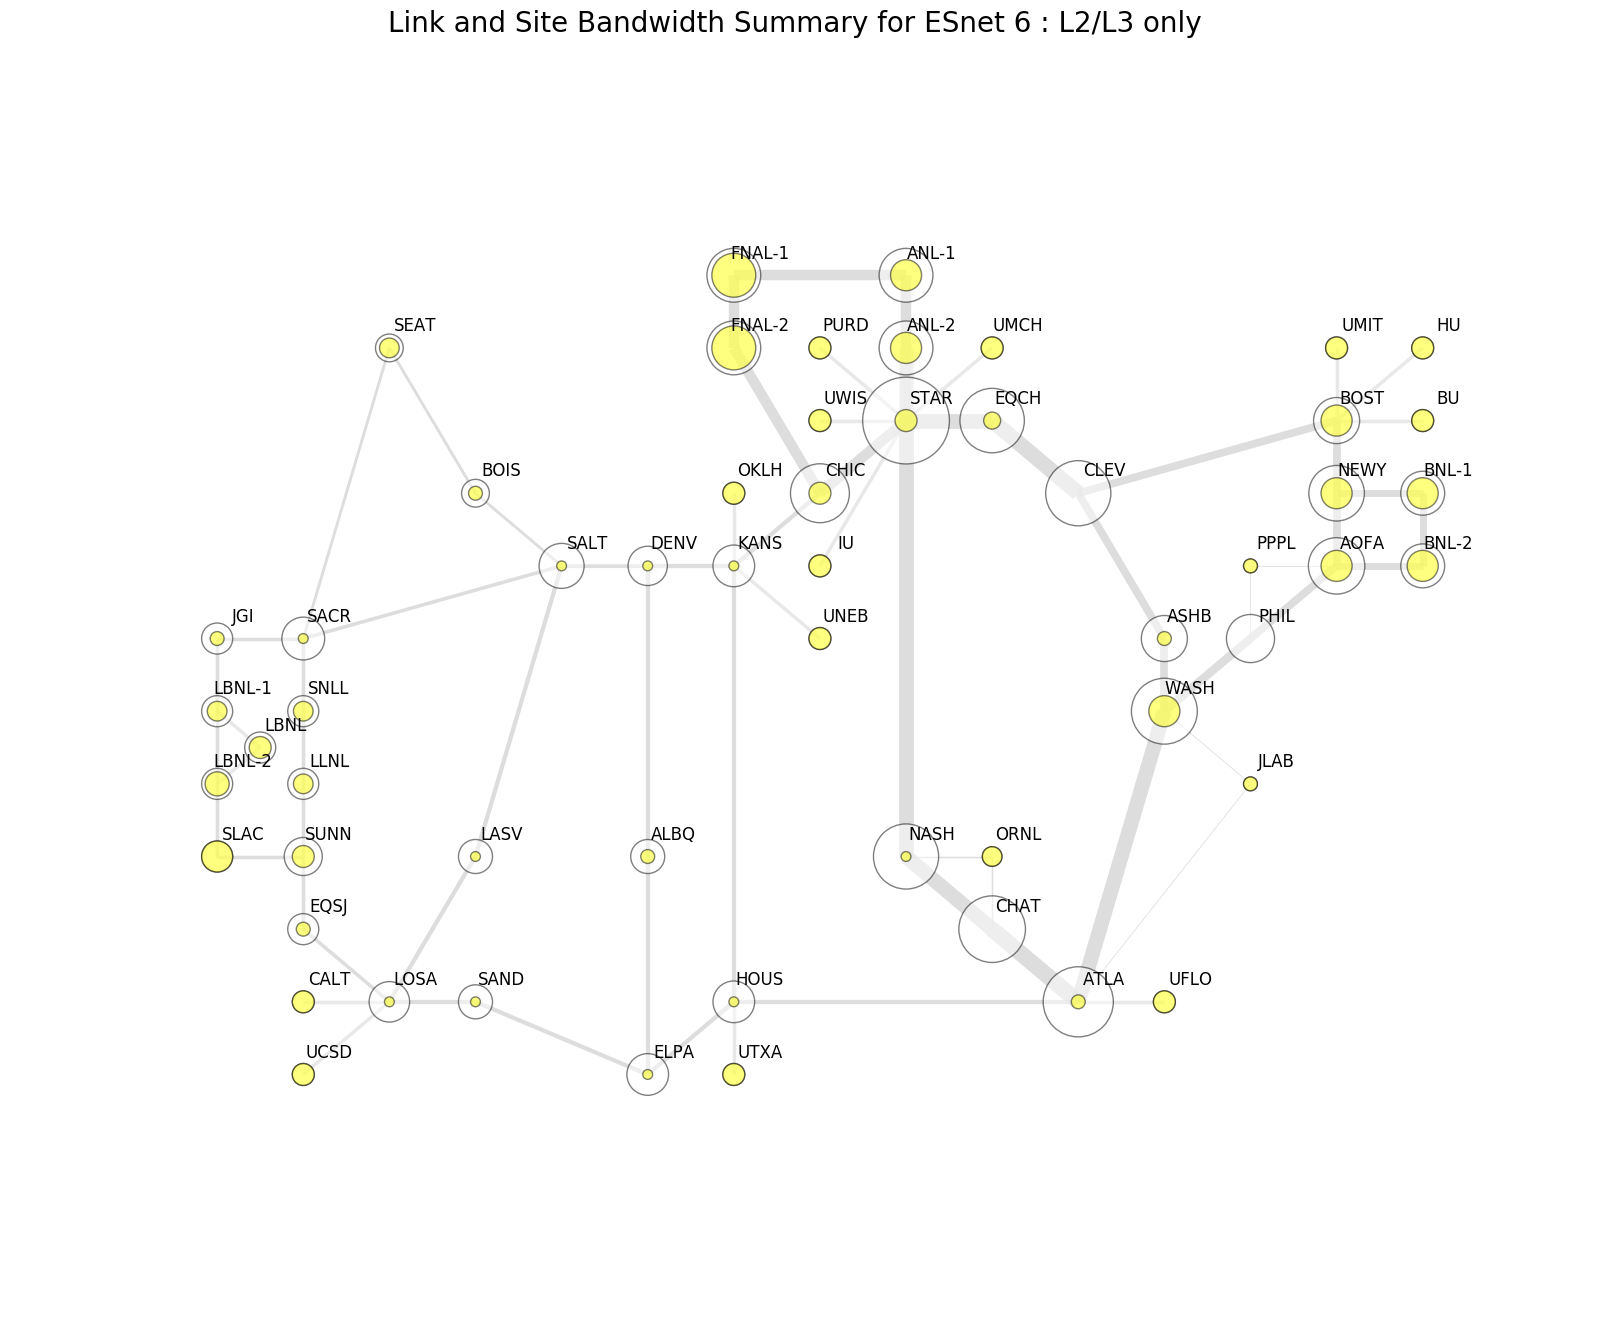

In [74]:
fig = plt.figure(figsize=(20,15))
plt.axis('off')

drawBaseMap(G , node_color='yellow')

fig.suptitle('Link and Site Bandwidth Summary for ESnet 6 : L2/L3 only', fontsize=20)

plt.show()

In [75]:
# paths_from_slac = nx.single_source_shortest_path(G,'SLAC')

dijkstra_source = 'HOUS'
dijkstra_dest = 'SLAC'
paths_from_dijkstra = nx.single_source_dijkstra_path(G,dijkstra_source,weight='impedance')
aPath = paths_from_dijkstra[dijkstra_dest]
path_edges = zip(aPath,aPath[1:])

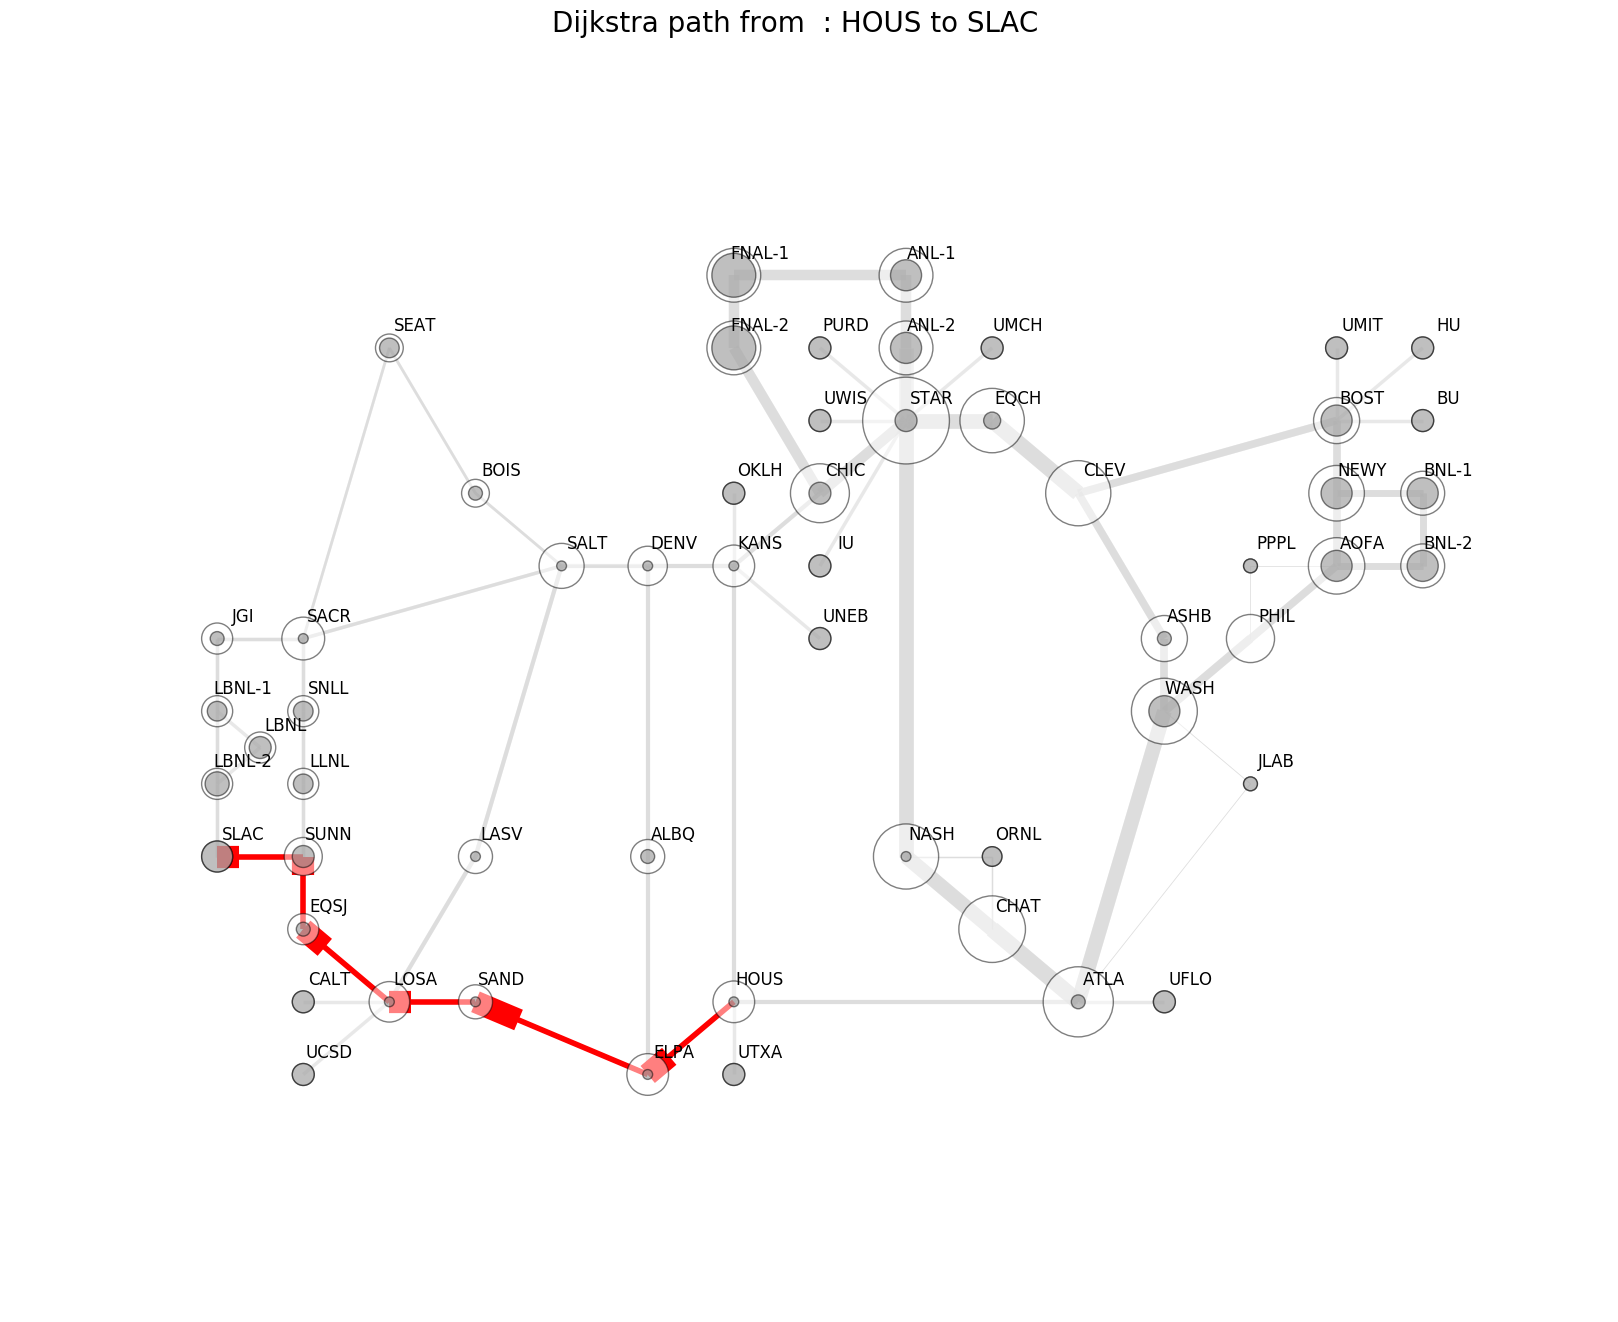

In [76]:
fig = plt.figure(figsize=(20,15))
plt.axis('off')
drawBaseMap(G)

fig.suptitle('Dijkstra path from  : ' + dijkstra_source + " to " + dijkstra_dest, fontsize=20)
nx.draw_networkx_edges (G , pos=pos, edgelist=path_edges   , edge_color='r', width=4 , arrows='true')

plt.show()

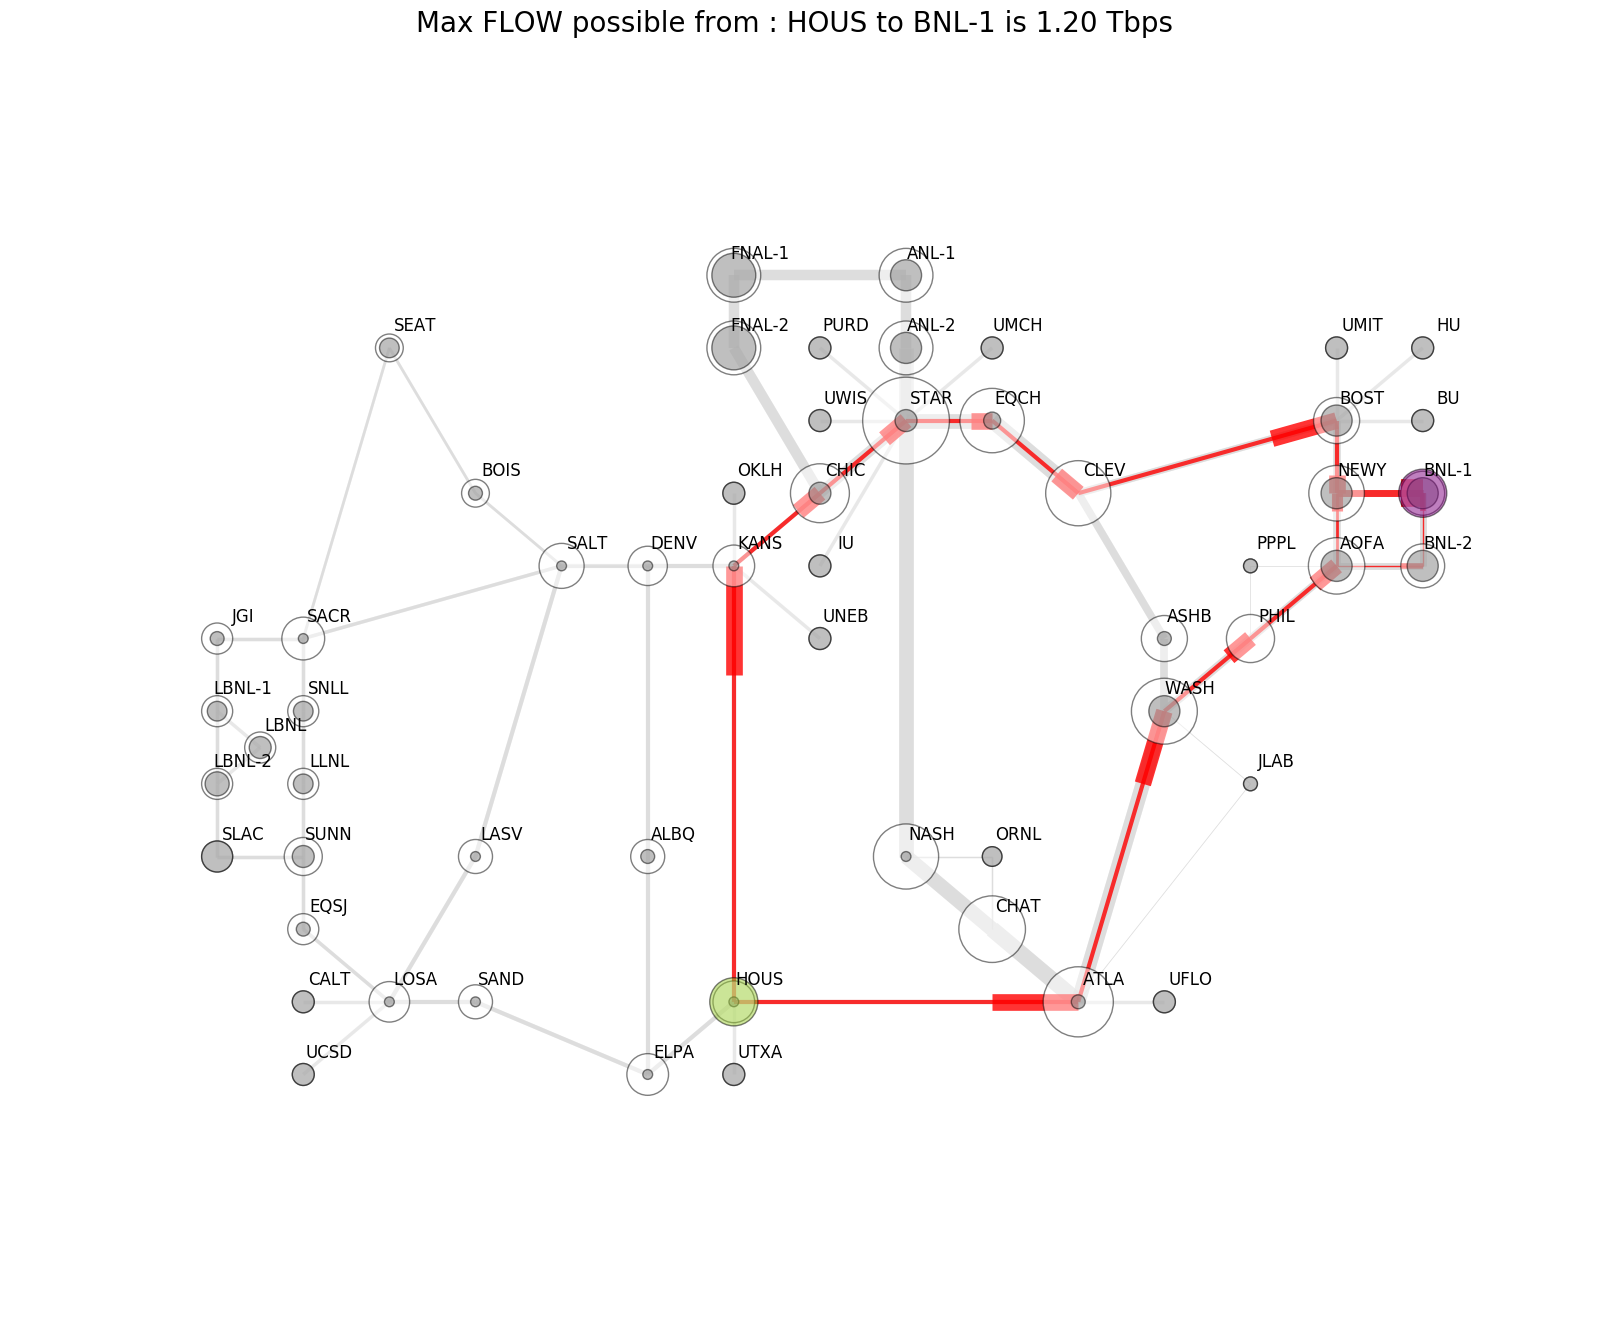

In [78]:
from networkx.algorithms.flow import shortest_augmenting_path
from networkx.algorithms.flow import edmonds_karp

flow_source = 'HOUS'
flow_dest   = 'BNL-1'
flow_rate , flows = nx.maximum_flow(G, flow_source, flow_dest , flow_func=edmonds_karp)

fig = plt.figure(figsize=(20,15))
plt.axis('off')
fig.suptitle('Max FLOW possible from : ' + flow_source + " to " + flow_dest + " is %2.2f Tbps" % flow_rate, 
             fontsize=20)

drawBaseMap(G)   # Draw the background image of the network
highlightNodes(G , nodelist=[flow_source, flow_dest], node_color=['yellowgreen','purple'])

# Plot the FLOW paths.  See nx.maximum_flows() to understand the "flows" datastructure.

for site , links in flows.items() :
    for link , rate in links.items() :
        if (rate > 0) :
            hightlightEdges(G , edgelist=[(site,link)] , rate=rate ,  alpha=0.8)
            
plt.show()

In [79]:
#pd.DataFrame(flows)


In [80]:
mc = nx.all_shortest_paths(G,'HOUS','BNL-1',weight='impedance')

In [51]:
print ([p for p in mc])

[['HOUS', 'ATLA', 'WASH', 'PHIL', 'AOFA', 'NEWY', 'BNL-1']]
